# MCI vs Circuitscape Integration Tests

This notebook validates that MCI's `solve_window_circuit` produces the same effective resistance as an independent Circuitscape solve on identical circuits.

**How it works:** For each test, we:
1. Run MCI's sliding-window `compute_mci` to get an R_eff value.
2. Build the same conductance/source/ground grids and solve them independently via Circuitscape's `compute_advanced_data` + `multiple_solver`.
3. Compare the two R_eff values.


## Setup

In [2]:
using Pkg
Pkg.activate("..")

using Test
using CairoMakie
using Circuitscape
using SparseArrays
using Statistics
using Printf
using Random

using MerriamConnectivityIndicator

  Activating project at `~/Code/Workspaces/MerriamConnectivityIndicator`


## Helper Functions

### Visualization: Single-Window Verification

Produces a 2x3 panel figure for each single-window test:
1. Base resistance (raw input)
2. Spoke/center map with circular mask
3. Source grid (injected current)
4. Current density from Circuitscape
5. R_eff bar chart comparison
6. Summary statistics

In [19]:
function visualize_verification_square(
    test_name::String,
    resistance_original::Matrix{T},
    conductance_masked::Matrix{T},
    source_grid::Matrix{T},
    cs_current_map::Matrix{T},
    mci_val::T,
    cs_val::T;
    center_r::Int,
    center_c::Int
) where T <: AbstractFloat

    fig = Figure(size = (1400, 800), title = "Verification: $test_name")

    xticks = 1:size(resistance_original, 2)
    yticks = 1:size(resistance_original, 1)

    # Panel 1: Base Resistance Layer
    ax1 = Axis(fig[1, 1], title = "1. Base Resistance", aspect = DataAspect(), xticks=xticks, yticks=yticks)
    hm1 = heatmap!(ax1, resistance_original', colormap = :viridis)
    Colorbar(fig[1, 1][1, 2], hm1, label = "Ohms", width = 10)

    # Panel 2: Spoke/Center Map (Geometry)
    disp_res = copy(resistance_original)
    disp_res[conductance_masked .== 0] .= NaN

    ax2 = Axis(fig[1, 2], title = "2. Spoke/Center Map (Masked)", aspect = DataAspect(), xticks=xticks, yticks=yticks)
    heatmap!(ax2, disp_res', colormap = :Greys, nan_color = :lightgray)

    spokes = findall(x -> x > 0, source_grid)
    src_pts = [Point2f(pt[2], pt[1]) for pt in spokes]

    scatter!(ax2, src_pts, color = :red, marker = :circle, markersize = 12, label = "Spoke")
    scatter!(ax2, [Point2f(center_c, center_r)], color = :blue, marker = :cross, markersize = 15, strokewidth=3, label = "Center")
    axislegend(ax2, position = :rb, bgcolor = (:white, 0.8), framevisible = false)

    # Panel 3: Source Grid (Heatmap of actual injected values)
    ax3 = Axis(fig[1, 3], title = "3. Source Grid (Current Injection)", aspect = DataAspect(), xticks=xticks, yticks=yticks)
    hm3 = heatmap!(ax3, source_grid', colormap = Reverse(:heat))
    Colorbar(fig[1, 3][1, 2], hm3, label = "Amps", width = 10)

    # Panel 4: Current Density
    ax4 = Axis(fig[2, 1], title = "4. Current Density (Circuitscape)", aspect = DataAspect(), xticks=xticks, yticks=yticks)
    hm4 = heatmap!(ax4, cs_current_map', colormap = :lipari)
    Colorbar(fig[2, 1][1, 2], hm4, label = "Amps", width = 10)

    # Panel 5: Result Comparison
    ax5 = Axis(fig[2, 2], title = "5. Effective Resistance",
               xticks = (1:2, ["MCI", "Circuitscape"]),
               ylabel = "ER (Ohms)",
               limits = (0, 3, 0, max(mci_val, cs_val) * 1.25), xgridvisible=false)
    barplot!(ax5, [1, 2], [mci_val, cs_val], color = [:teal, :orange], width = 0.5)
    text!(ax5, 1, mci_val, text = @sprintf("%.4f", mci_val), align = (:center, :bottom))
    text!(ax5, 2, cs_val, text = @sprintf("%.4f", cs_val), align = (:center, :bottom))

    # Panel 6: Statistics / Info
    diff = abs(mci_val - cs_val)
    info_text = """
    TEST STATISTICS

    Target:
    \t - Center: ($center_r, $center_c)
    \t - Valid Spokes: $(length(spokes))

    Results:
    \t - MCI Value:   $(round(mci_val, digits=5))
    \t - Validator:   $(round(cs_val, digits=5))

    Status: $(diff < 1e-4 ? "PASS" : "FAIL")
    """

    ax6 = Axis(fig[2, 3], title = "6. Summary")
    hidedecorations!(ax6)
    hidespines!(ax6)
    text!(ax6, 0.5, 0.5, text = info_text, align = (:center, :center), fontsize = 14)

    return fig
end

visualize_verification_square (generic function with 1 method)

### Visualization: Sliding Window Comparison

Shows the MCI raster, the independent validator raster, and a 1:1 correlation scatter plot.

In [21]:
function visualize_sliding_comparison(
    test_name::String,
    mci_raster::Matrix{T},
    validator_raster::Matrix{T}
) where T <: AbstractFloat

    fig = Figure(size = (1400, 400), title = "Sliding Window Validation: $test_name")

    # Panel 1: MCI Output
    ax1 = Axis(fig[1, 1], title = "MCI Output", aspect = DataAspect())
    hm1 = heatmap!(ax1, mci_raster', colormap = :viridis, nan_color = :lightgray)
    Colorbar(fig[1, 2], hm1, label = "MCI Value")

    # Panel 2: Validator Output
    ax2 = Axis(fig[1, 3], title = "Circuitscape Validator", aspect = DataAspect())
    hm2 = heatmap!(ax2, validator_raster', colormap = :viridis, nan_color = :lightgray)
    Colorbar(fig[1, 4], hm2, label = "R_eff")

    # Panel 3: Correlation Plot
    ax3 = Axis(fig[1, 5], xlabel = "MCI Value", ylabel = "Validator Value")

    valid_mask = .!isnan.(mci_raster) .& .!isnan.(validator_raster)
    x_vals = mci_raster[valid_mask]
    y_vals = validator_raster[valid_mask]

    if !isempty(x_vals)
        scatter!(ax3, x_vals, y_vals, color = :blue, markersize = 10, label = "Pixels")
        lines!(ax3, [minimum(x_vals), maximum(x_vals)], [minimum(x_vals), maximum(x_vals)],
               color = :red, linestyle = :dash, label = "1:1")
    end
    axislegend(ax3, position=:rb)

    return fig
end

visualize_sliding_comparison (generic function with 1 method)

### Independent Circuitscape Solver (Test Validator)

This function computes R_eff by calling Circuitscape's Advanced-mode internals directly.
It is equivalent to `cs_current_and_er` from Bronwyn's work.

**Algorithm:**

1. Package conductance/source/ground grids into `RasterData` + `RasterFlags`.
2. Call `compute_advanced_data` to build the graph and detect connected components.
3. For each connected component that has both sources and grounds:
   - Solve for node voltages via `multiple_solver`.
   - Map voltages back to a 2D grid 
   - Accumulate **power**: `P += sum(source_grid .* voltage_grid)`
   - Accumulate **actual current**: `I += sum(data.sources[component])` (post-rmvsrc)
4. Compute `R_eff = P / I_actual^2`.

The denominator uses `I_actual` (the current that actually flows after `rmvsrc` removes sources co-located with ground), **not** the nominal injected current. This matches `cs_current_and_er` (line 88) and `solve_window_circuit` (line 132).

In [33]:
function compute_circuitscape_effective_resistance(
    conductance_grid::Array{T, 2},
    source_grid::Array{T, 2},
    ground_grid::Array{T, 2};
    use_four_neighbors::Bool = true
) where T <: AbstractFloat

    node_index_type = Int64
    value_type = T

    # --- Package grids into Circuitscape data structures ---
    raster_metadata = Circuitscape.RasterMeta(
        size(conductance_grid, 2), size(conductance_grid, 1),
        0.0, 0.0, 1.0, -9999.0, Array{value_type, 1}(undef, 1), ""
    )

    raster_data = Circuitscape.RasterData(
        conductance_grid, Matrix{node_index_type}(undef, 0, 0),
        source_grid, ground_grid,
        (node_index_type[], node_index_type[], node_index_type[]),
        Matrix{value_type}(undef, 0, 0),
        Circuitscape.IncludeExcludePairs(:undef, node_index_type[], Matrix{node_index_type}(undef, 0, 0)),
        raster_metadata
    )

    cs_config = Dict{String, String}(
        "solver" => "cg+amg",
        "connect_four_neighbors_only" => use_four_neighbors ? "true" : "false",
        "suppress_messages" => "true",
        "data_type" => "int",
    )

    # RasterFlags positional fields (from Circuitscape source):
    #   is_raster, is_pairwise, is_advanced, is_onetoall, is_alltoone,
    #   grnd_file_is_res, policy, four_neighbors, avg_res, solver, outputflags
    processing_flags = Circuitscape.RasterFlags(
        true,                           # is_raster
        false,                          # is_pairwise (advanced mode, not pairwise)
        true,                           # is_advanced
        false,                          # is_onetoall
        false,                          # is_alltoone
        false,                          # grnd_file_is_res
        Symbol("rmvsrc"),               # policy \u2014 removes sources at ground
        cs_config["connect_four_neighbors_only"] in Circuitscape.TRUELIST,
        false, cs_config["solver"],
        Circuitscape.OutputFlags(false, false, false, false, false, false, false, false)
    )

    # --- Build graph + detect connected components ---
    circuit_data = Circuitscape.compute_advanced_data(raster_data, processing_flags, cs_config)
    current_map = Circuitscape.alloc_map(raster_metadata)

    power_accumulated = zero(value_type)
    current_accumulated = zero(value_type)

    for component_nodes in circuit_data.cc
        # Skip components that don't include the check node (if set)
        if circuit_data.check_node != -1 && !(circuit_data.check_node in component_nodes)
            continue
        end

        laplacian_local = circuit_data.G[component_nodes, component_nodes]
        sources_local = circuit_data.sources[component_nodes]      # post-rmvsrc
        grounds_local = circuit_data.grounds[component_nodes]

        if sum(sources_local) == 0 || sum(grounds_local) == 0; continue; end

        finite_grounds_local = circuit_data.finitegrounds != [-9999.] ?
                               circuit_data.finitegrounds[component_nodes] : circuit_data.finitegrounds

        voltages_local = Circuitscape.multiple_solver(
            cs_config, circuit_data.solver, laplacian_local,
            sources_local, grounds_local, finite_grounds_local
        )

        local_node_map = Circuitscape.construct_local_node_map(
            circuit_data.nodemap, component_nodes, circuit_data.polymap
        )

        Circuitscape.accum_currents!(
            current_map, voltages_local, cs_config, laplacian_local,
            voltages_local, finite_grounds_local, local_node_map, raster_metadata
        )

        # Reconstruct voltage grid (ground nodes stay at V=0)
        voltage_grid = zeros(value_type, size(source_grid))
        for r in 1:size(local_node_map, 1)
            for c in 1:size(local_node_map, 2)
                idx = local_node_map[r, c]
                if idx > 0; voltage_grid[r, c] = voltages_local[idx]; end
            end
        end

        # P += ∑(source .* V), sources at ground contribute 0 (V=0 there)
        power_accumulated += sum(source_grid .* voltage_grid)
        # I += actual amps in this component (after rmvsrc removal)
        current_accumulated += sum(sources_local)
    end

    # R_eff = P / I_actual^2
    effective_resistance = current_accumulated == 0 ? zero(value_type) : power_accumulated / (current_accumulated^2)
    return current_map, effective_resistance
end

compute_circuitscape_effective_resistance (generic function with 1 method)

### Grid Builder

Constructs source and ground grids for manual Circuitscape validation.
The center pixel gets `Inf` ground (voltage = 0); current is split equally across spoke positions.

In [23]:
function build_mci_source_ground_grids(
    grid_size::Tuple{Int, Int},
    center_row::Int,
    center_col::Int,
    spoke_positions::Vector{Tuple{Int, Int}},
    total_current::Float64
)
    source_grid = zeros(Float64, grid_size)
    ground_grid = zeros(Float64, grid_size)
    ground_grid[center_row, center_col] = Inf

    current_per_spoke = total_current / length(spoke_positions)
    for (r, c) in spoke_positions
        source_grid[r, c] = current_per_spoke
    end
    return source_grid, ground_grid
end

build_mci_source_ground_grids (generic function with 1 method)

---

## Test 1: 3x3 Uniform Resistance (4-neighbors)

**Goal:** Verify basic connectivity on the simplest possible grid.

- 3x3 grid, all cells have resistance = 1.0
- 4 spokes at the cardinal neighbors of center pixel (2,2)
- 4-neighbor connectivity (no diagonals)
- Each spoke injects 0.25 A (total = 1.0 A), center is ground

In [24]:
Random.seed!(42)

resistance = ones(Float64, 3, 3)
conductance = 1.0 ./ resistance

config = MerriamConnectivityIndicator.MCIConfig(
    search_radius = 1, num_spokes = 4, injected_current = 1.0,
    connect_four_neighbors = true
)

# Run MCI
mci_res = MerriamConnectivityIndicator.compute_mci(resistance, config, parallelize=false, verbose=false)
mci_val = mci_res[2, 2]

# Run independent Circuitscape validator
spokes = [(1,2), (2,1), (2,3), (3,2)]
src, gnd = build_mci_source_ground_grids((3,3), 2, 2, spokes, 1.0)
cur_map, cs_val = compute_circuitscape_effective_resistance(conductance, src, gnd, use_four_neighbors=true)

println("MCI R_eff:          $(round(mci_val, digits=6))")
println("Circuitscape R_eff: $(round(cs_val, digits=6))")
println("Match: $(isapprox(mci_val, cs_val, rtol=0.01) ? "PASS" : "FAIL")")

MCI R_eff:          0.25
Circuitscape R_eff: 0.25
Match: PASS


┌ Warning: Keyword argument `bgcolor` is deprecated, use `backgroundcolor` instead.
└ @ Makie /Users/michael/.julia/packages/Makie/Vn16E/src/makielayout/blocks/legend.jl:63


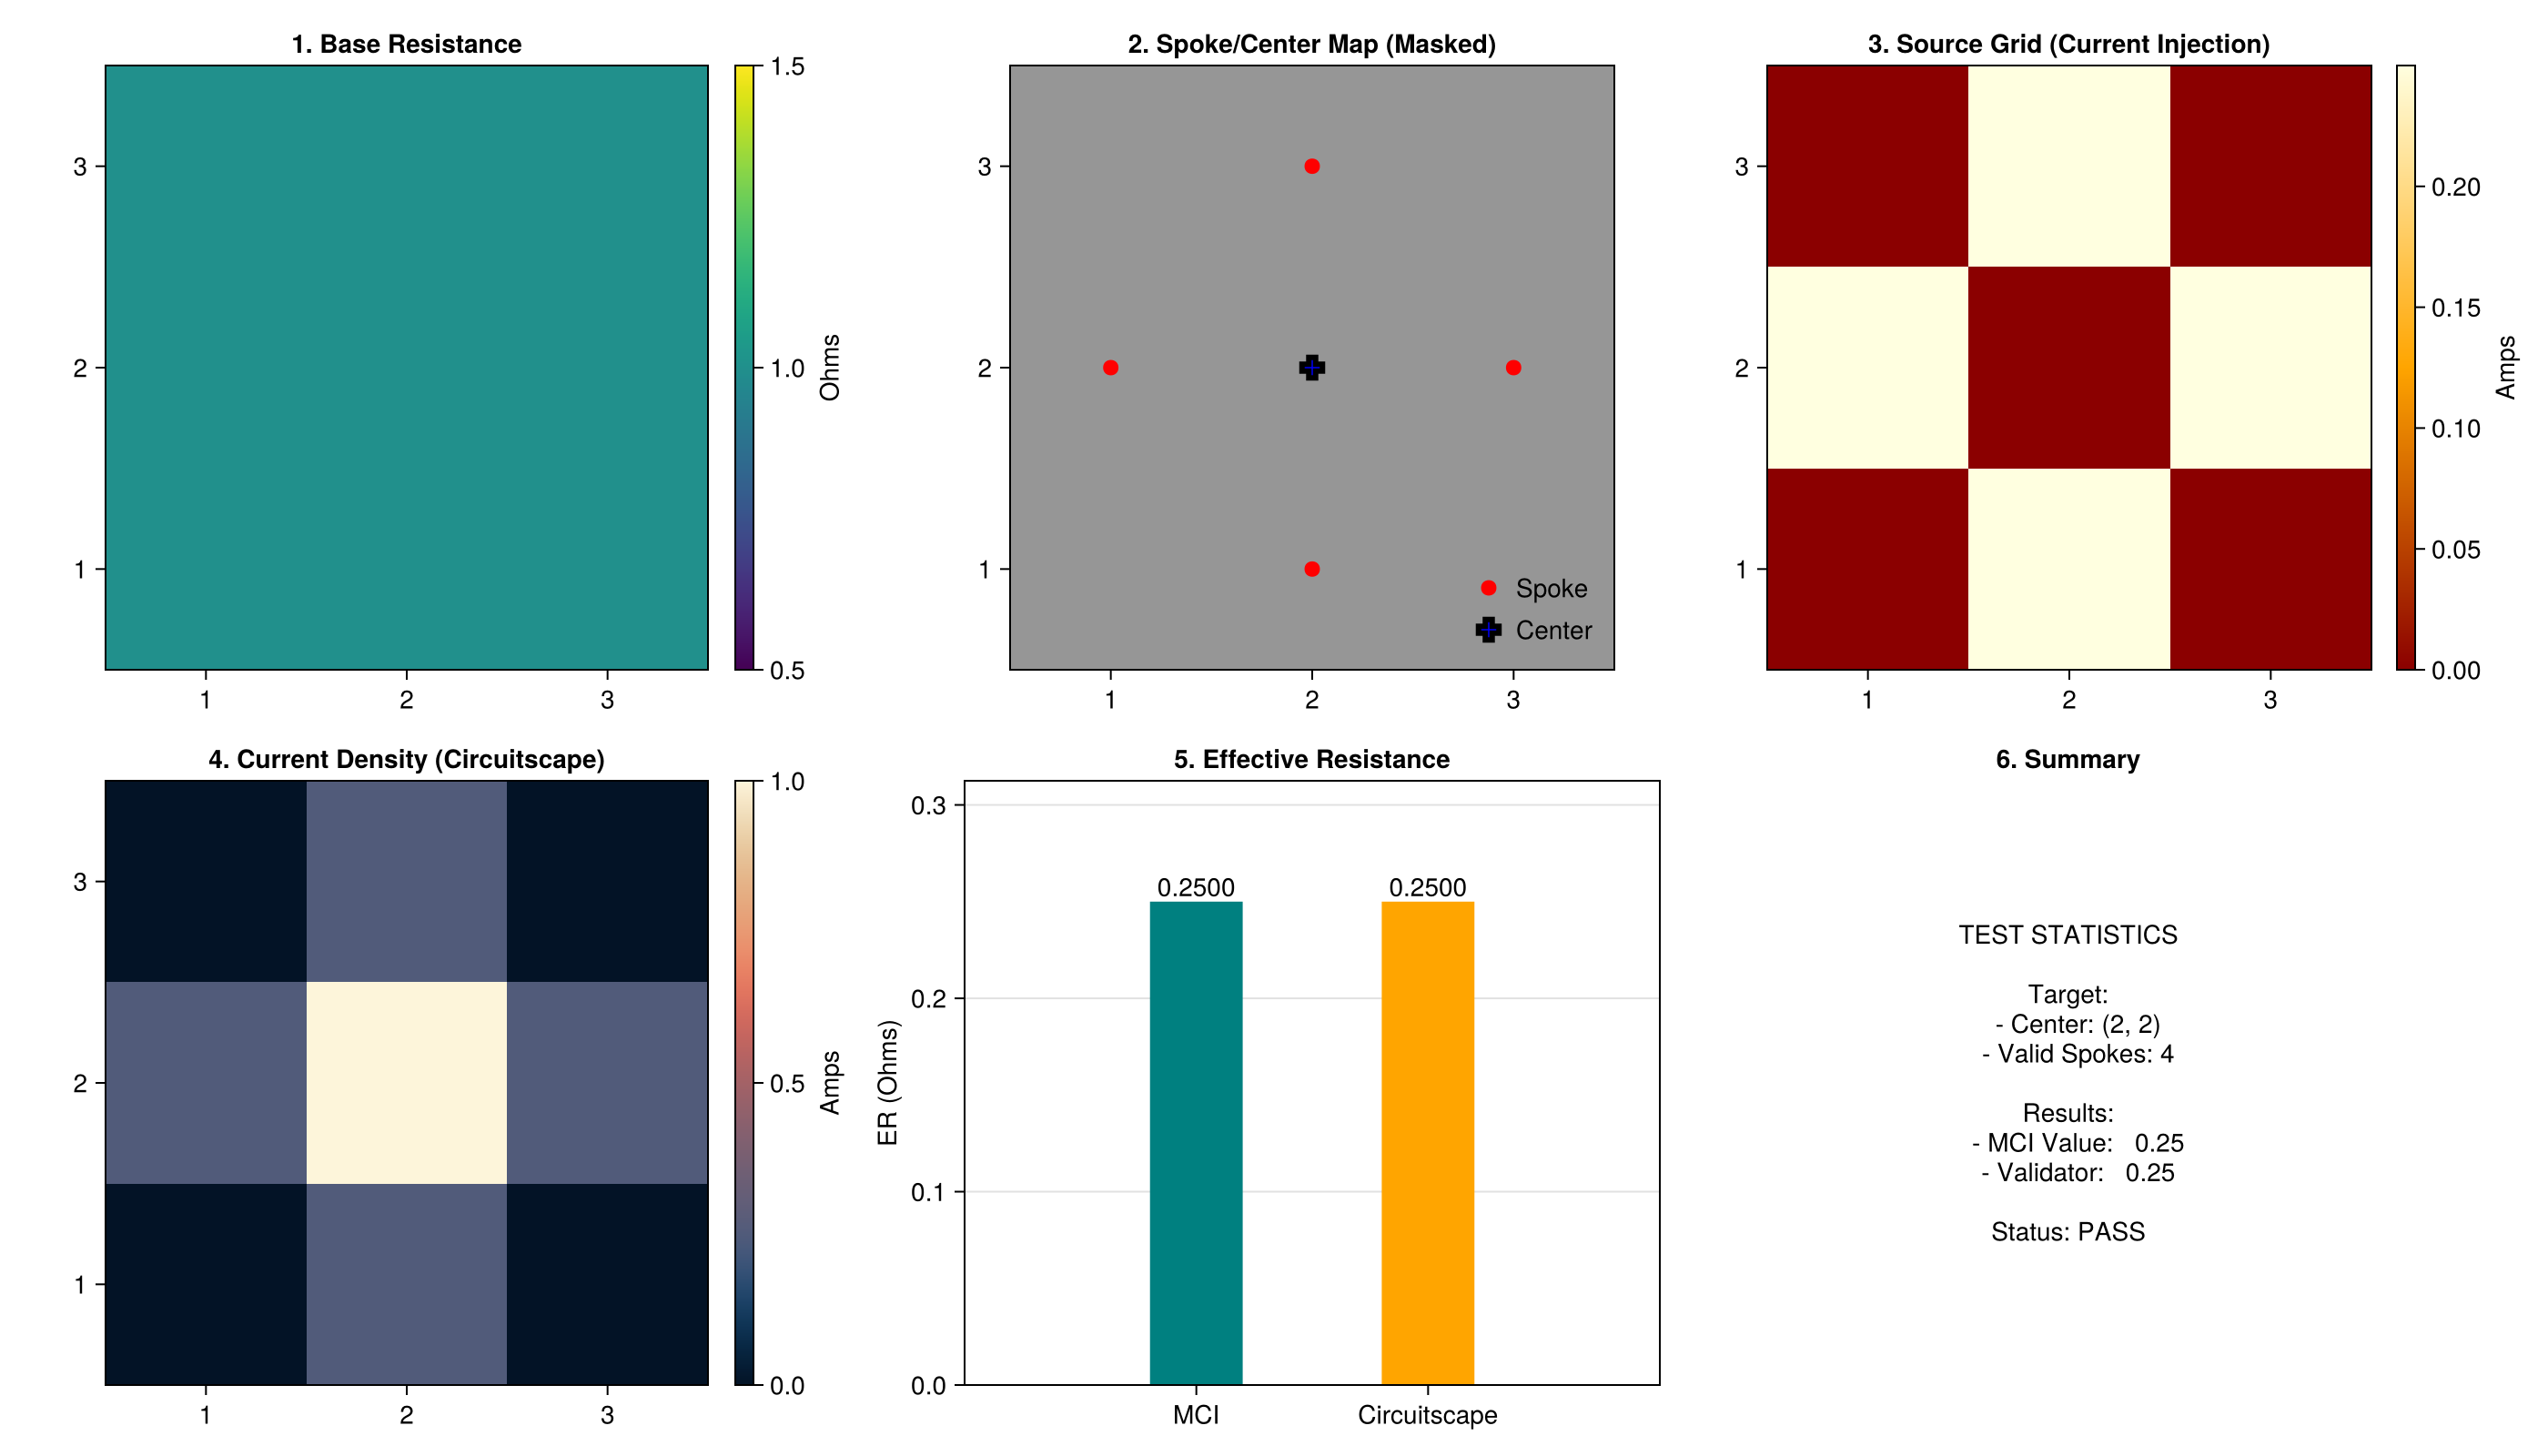

In [25]:
visualize_verification_square(
    "3x3 Uniform", resistance, conductance, src, cur_map, mci_val, cs_val,
    center_r = 2, center_c = 2
)

---

## Test 2: 3x3 Resistance Gradient (4-neighbors)

**Goal:** Verify heterogeneous resistance handling.

- 3x3 grid with a diagonal gradient (corners vary from 1.0 to 3.0)
- Same 4-spoke layout as Test 1
- Asymmetric resistance means spokes develop different voltages

In [26]:
resistance = Float64[1.0 2.0 3.0; 2.0 1.0 2.0; 3.0 2.0 1.0]
conductance = 1.0 ./ resistance

config = MerriamConnectivityIndicator.MCIConfig(
    search_radius = 1, num_spokes = 4, injected_current = 1.0,
    connect_four_neighbors = true
)

# Run MCI
mci_res = MerriamConnectivityIndicator.compute_mci(resistance, config, parallelize=false, verbose=false)
mci_val = mci_res[2, 2]

# Run independent Circuitscape validator
spokes = [(1,2), (2,1), (2,3), (3,2)]
src, gnd = build_mci_source_ground_grids((3,3), 2, 2, spokes, 1.0)
cur_map, cs_val = compute_circuitscape_effective_resistance(conductance, src, gnd, use_four_neighbors=true)

println("MCI R_eff:          $(round(mci_val, digits=6))")
println("Circuitscape R_eff: $(round(cs_val, digits=6))")
println("Match: $(isapprox(mci_val, cs_val, rtol=0.01) ? "PASS" : "FAIL")")

MCI R_eff:          0.333333
Circuitscape R_eff: 0.333333
Match: PASS


┌ Warning: Keyword argument `bgcolor` is deprecated, use `backgroundcolor` instead.
└ @ Makie /Users/michael/.julia/packages/Makie/Vn16E/src/makielayout/blocks/legend.jl:63


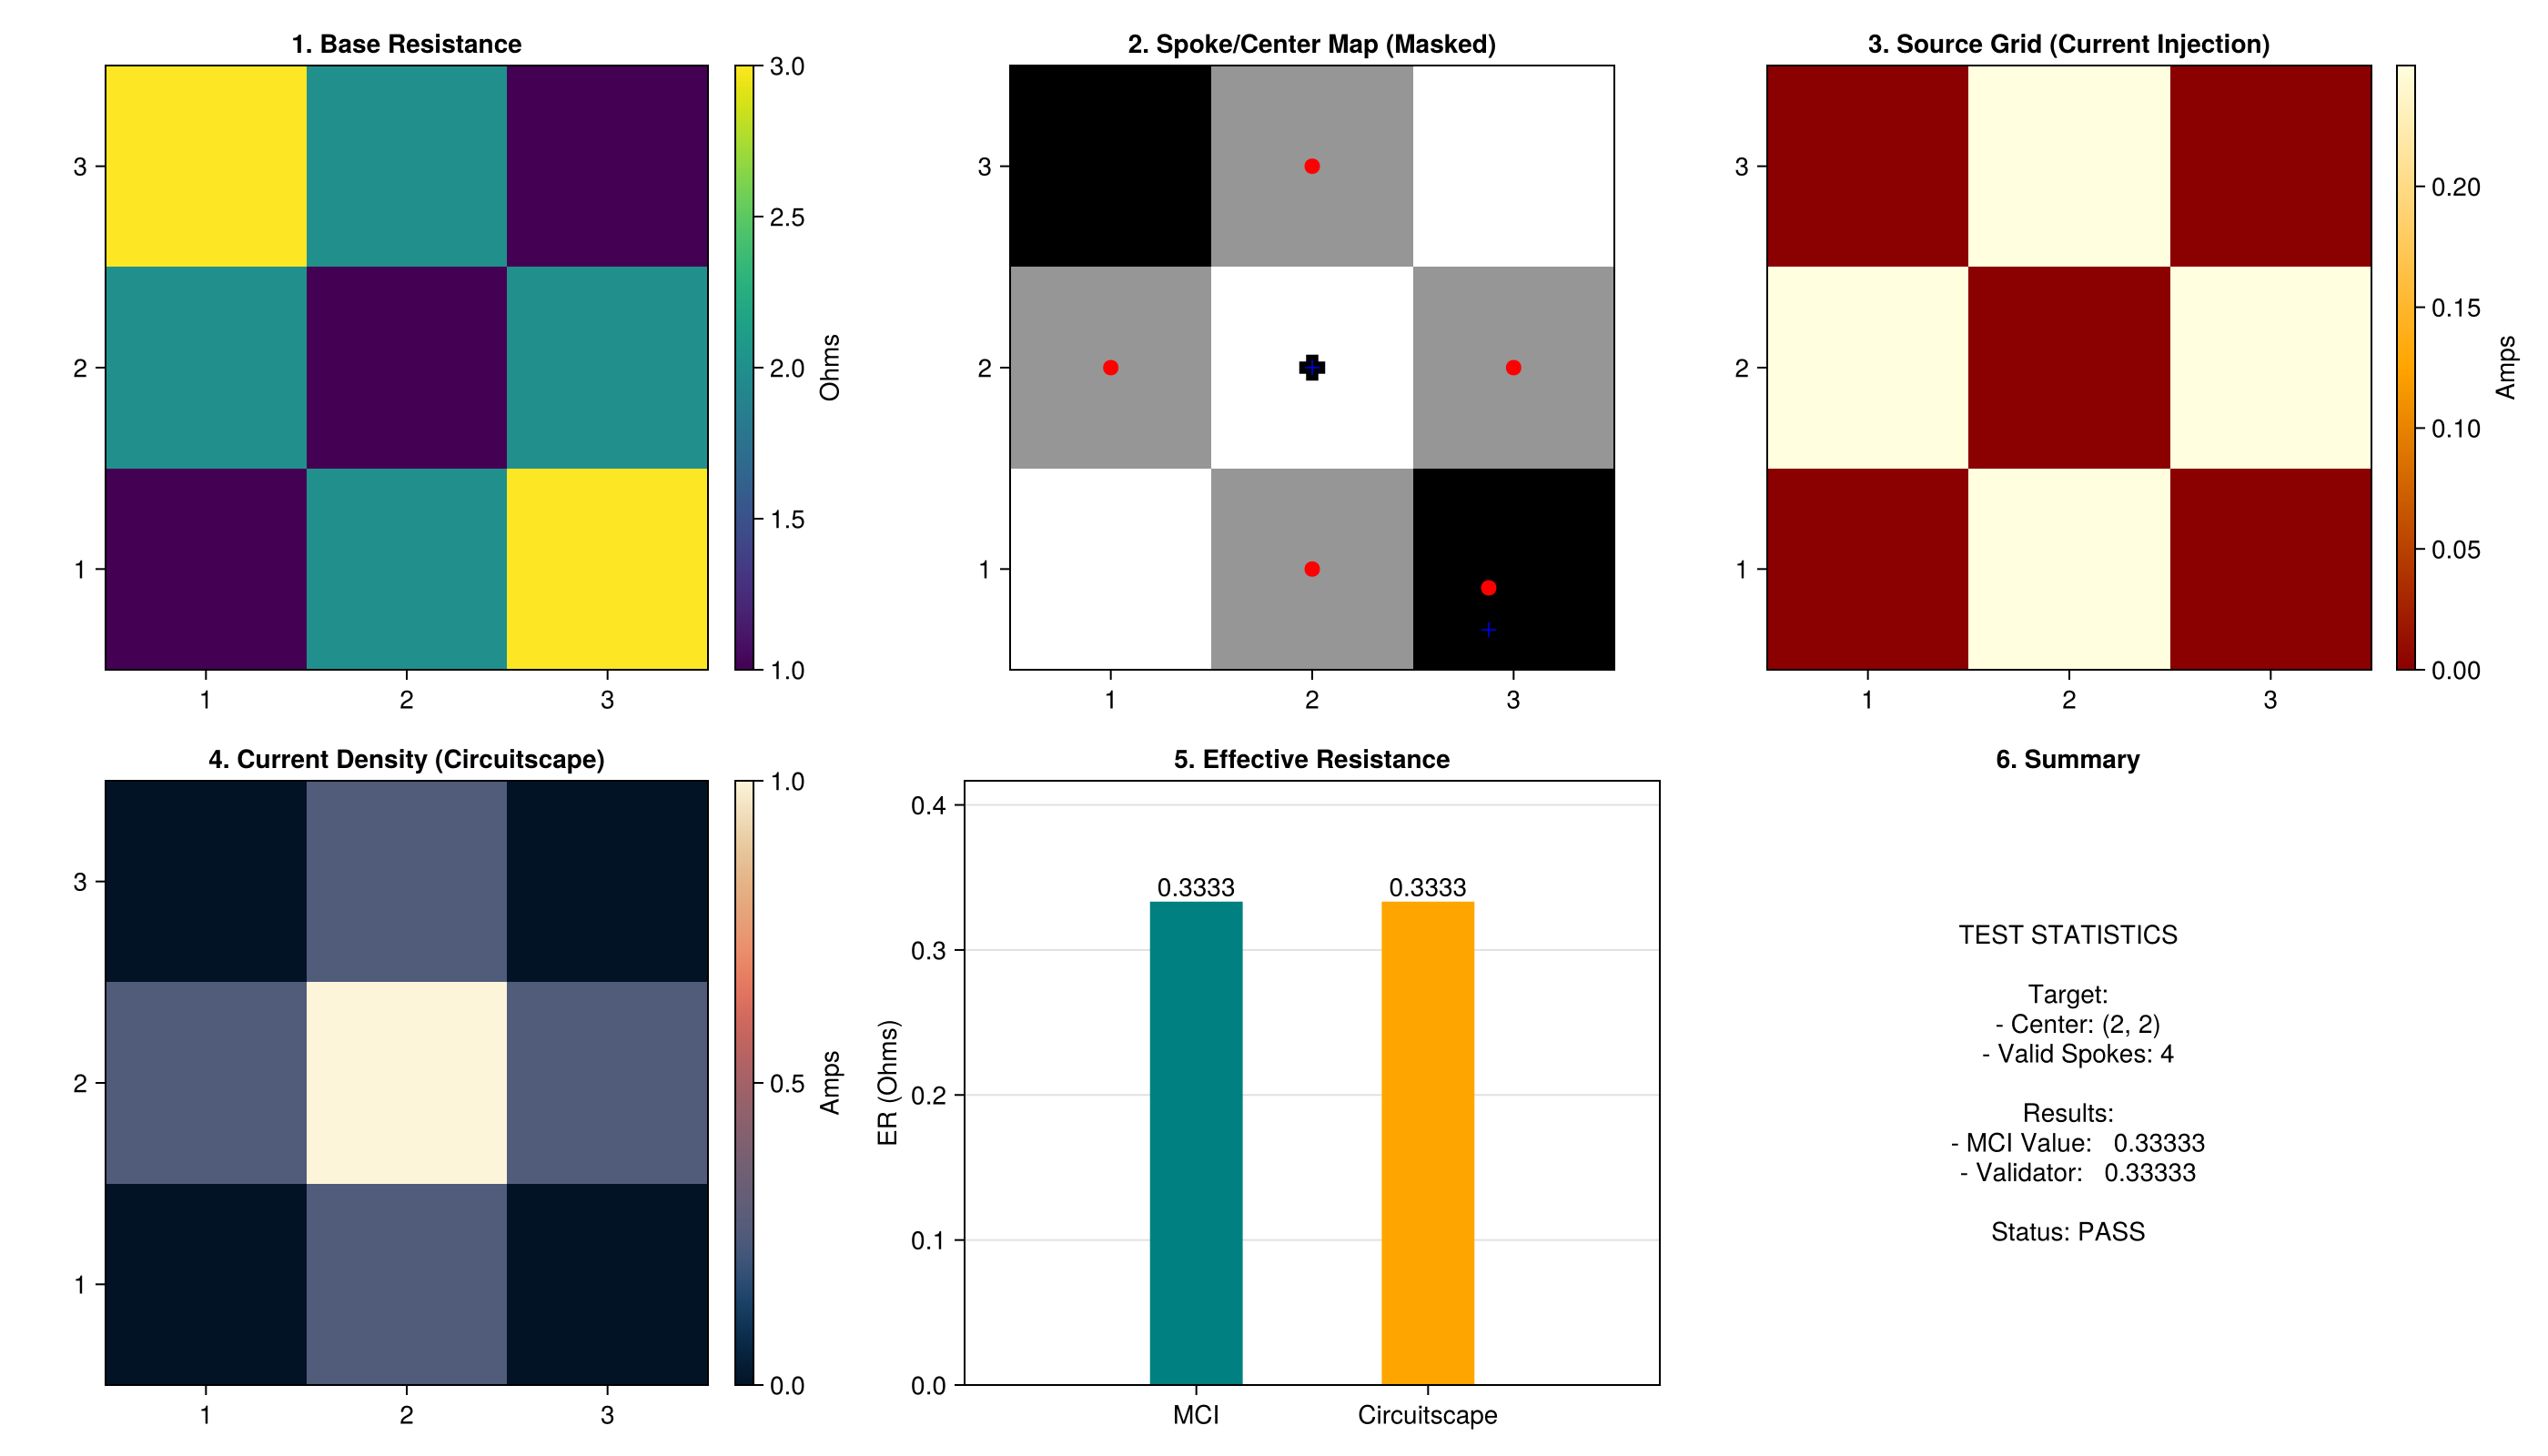

In [27]:
visualize_verification_square(
    "3x3 Gradient", resistance, conductance, src, cur_map, mci_val, cs_val,
    center_r = 2, center_c = 2
)

---

## Test 3: 5x5 Grid, Radius 2, Circular Mask (8-neighbors)

**Goal:** Verify circular masking logic matches the physics.

- 5x5 random resistance grid (seeded), center at (3,3) with low resistance
- Radius 2 circular mask: pixels beyond distance 2 from center are zeroed out
- 8 spokes on the circumference, 8-neighbor connectivity
- Manual Circuitscape setup applies the same circular mask to conductance

In [28]:
Random.seed!(42)

resistance = rand(Float64, 5, 5) .+ 0.5
resistance[3, 3] = 0.1  # Low resistance center
conductance = 1.0 ./ resistance

config = MerriamConnectivityIndicator.MCIConfig(
    search_radius = 2, num_spokes = 8, injected_current = 1.0,
    connect_four_neighbors = false  # 8-neighbor
)

# Run MCI
mci_res = MerriamConnectivityIndicator.compute_mci(resistance, config, parallelize=false, verbose=false)
mci_val = mci_res[3, 3]

# Manual Circuitscape setup: apply same circular mask
center_r, center_c = 3, 3
masked_cond = copy(conductance)
for r in 1:5, c in 1:5
    if sqrt((r - center_r)^2 + (c - center_c)^2) > 2
        masked_cond[r, c] = 0.0
    end
end

spoke_pts = MerriamConnectivityIndicator.generate_spoke_points(3, 3, 2, 8)
spokes = [(s.row, s.col) for s in spoke_pts if 1 <= s.row <= 5 && 1 <= s.col <= 5]

src, gnd = build_mci_source_ground_grids((5,5), 3, 3, spokes, 1.0)
cur_map, cs_val = compute_circuitscape_effective_resistance(masked_cond, src, gnd, use_four_neighbors=false)

println("MCI R_eff:          $(round(mci_val, digits=6))")
println("Circuitscape R_eff: $(round(cs_val, digits=6))")
println("Match: $(isapprox(mci_val, cs_val, rtol=0.01) ? "PASS" : "FAIL")")

MCI R_eff:          0.058341
Circuitscape R_eff: 0.058341
Match: PASS


┌ Warning: Keyword argument `bgcolor` is deprecated, use `backgroundcolor` instead.
└ @ Makie /Users/michael/.julia/packages/Makie/Vn16E/src/makielayout/blocks/legend.jl:63


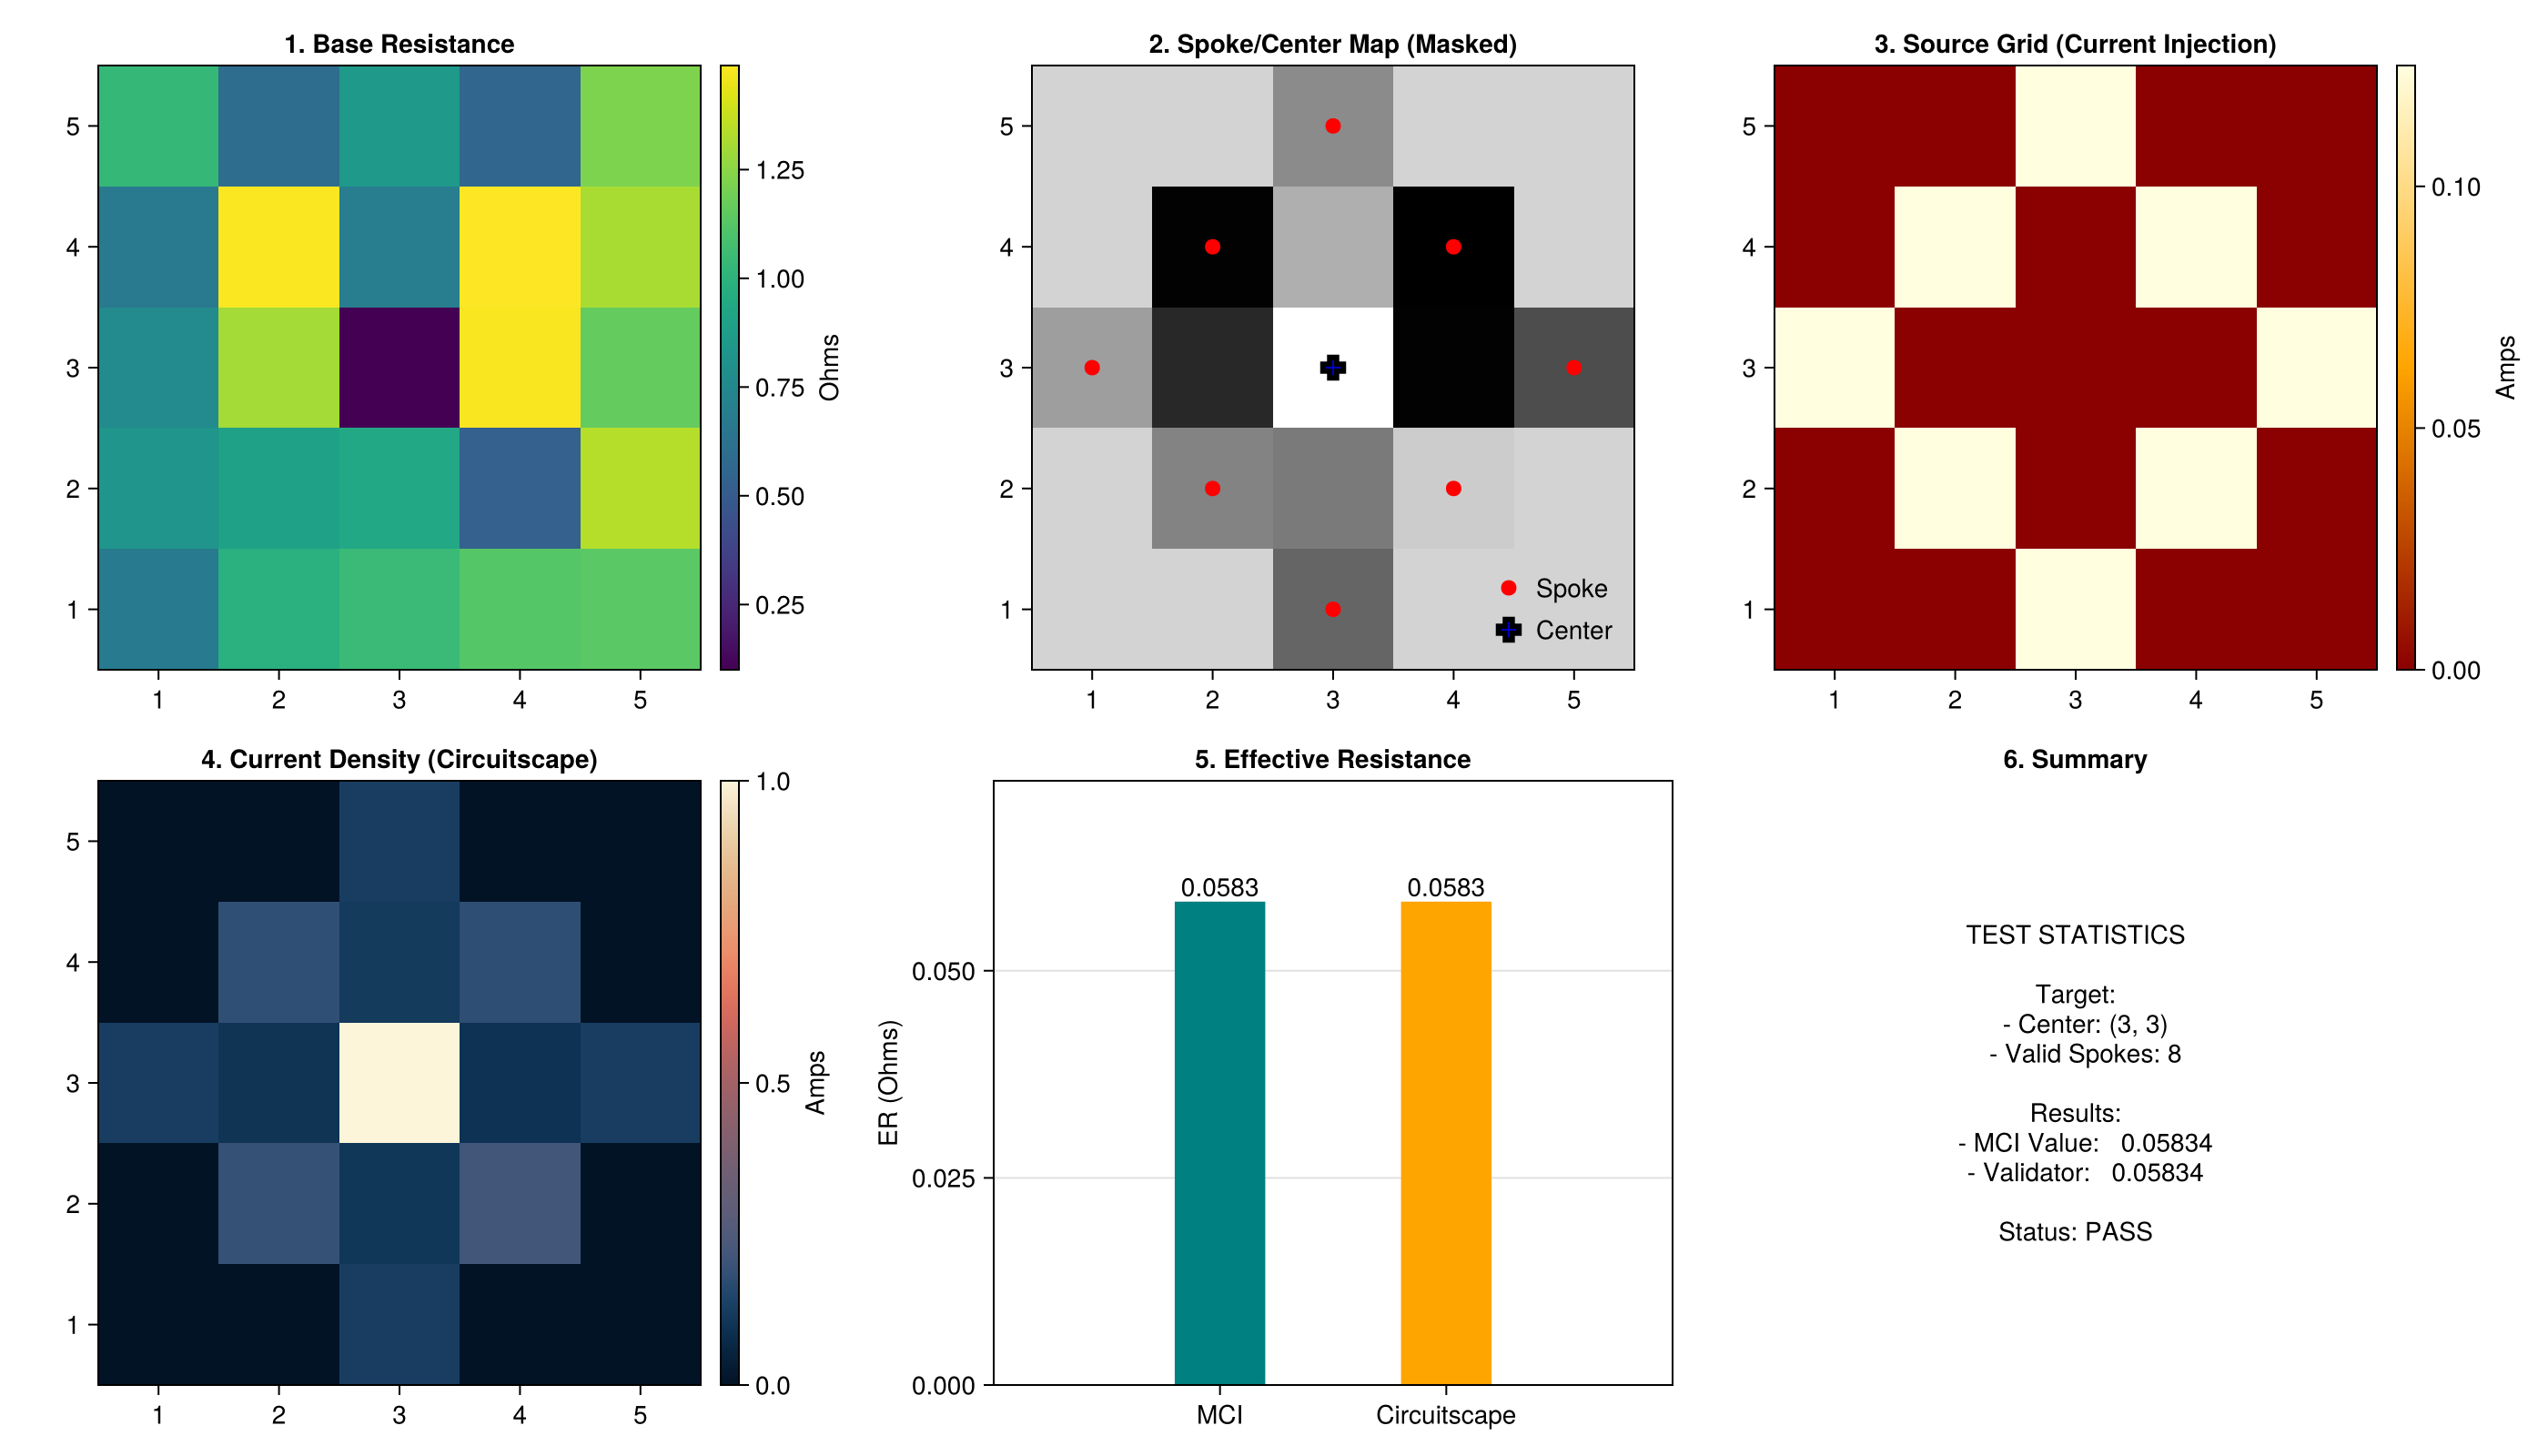

In [29]:
visualize_verification_square(
    "5x5 Radius 2", resistance, masked_cond, src, cur_map, mci_val, cs_val,
    center_r = center_r, center_c = center_c
)

---

## Test 4: 10x10 Gradient, Radius 4, 12 Spokes (8-neighbors)

**Goal:** Verify on a larger grid with many spokes and no pixel collisions.

- 10x10 gradient resistance: `R[r,c] = r + c`
- Center at (5,5), radius 4, 12 evenly-spaced spokes
- Uses `build_window_grids` to get the **exact** same grids MCI uses internally,
  ensuring the comparison is truly apples-to-apples

In [30]:
resistance = Float64[r + c for r in 1:10, c in 1:10]
conductance = 1.0 ./ resistance

center_r, center_c = 5, 5
radius = 4
injected_curr = 1.0

config = MerriamConnectivityIndicator.MCIConfig(
    search_radius = radius,
    num_spokes = 12,
    injected_current = injected_curr,
    connect_four_neighbors = false
)

# Run MCI
mci_res = MerriamConnectivityIndicator.compute_mci(resistance, config, parallelize=false, verbose=false)
mci_val = mci_res[center_r, center_c]

# Get the exact same grids MCI uses internally
masked_cond, source_grid, ground_grid = MerriamConnectivityIndicator.build_window_grids(
    resistance, center_r, center_c, config
)

# Check for spoke pixel collisions
valid_spoke_count = count(x -> x > 0, source_grid)
println("Valid spokes: $valid_spoke_count / 12 $(valid_spoke_count < 12 ? "(COLLISION!)" : "(all unique)")")

# Run independent Circuitscape validator
cur_map, cs_val = compute_circuitscape_effective_resistance(
    masked_cond, source_grid, ground_grid, use_four_neighbors=false
)

println("MCI R_eff:          $(round(mci_val, digits=6))")
println("Circuitscape R_eff: $(round(cs_val, digits=6))")
println("Match: $(isapprox(mci_val, cs_val, rtol=0.01) ? "PASS" : "FAIL")")

Valid spokes: 12 / 12 (all unique)
MCI R_eff:          2.334633
Circuitscape R_eff: 2.334633
Match: PASS


┌ Warning: Keyword argument `bgcolor` is deprecated, use `backgroundcolor` instead.
└ @ Makie /Users/michael/.julia/packages/Makie/Vn16E/src/makielayout/blocks/legend.jl:63


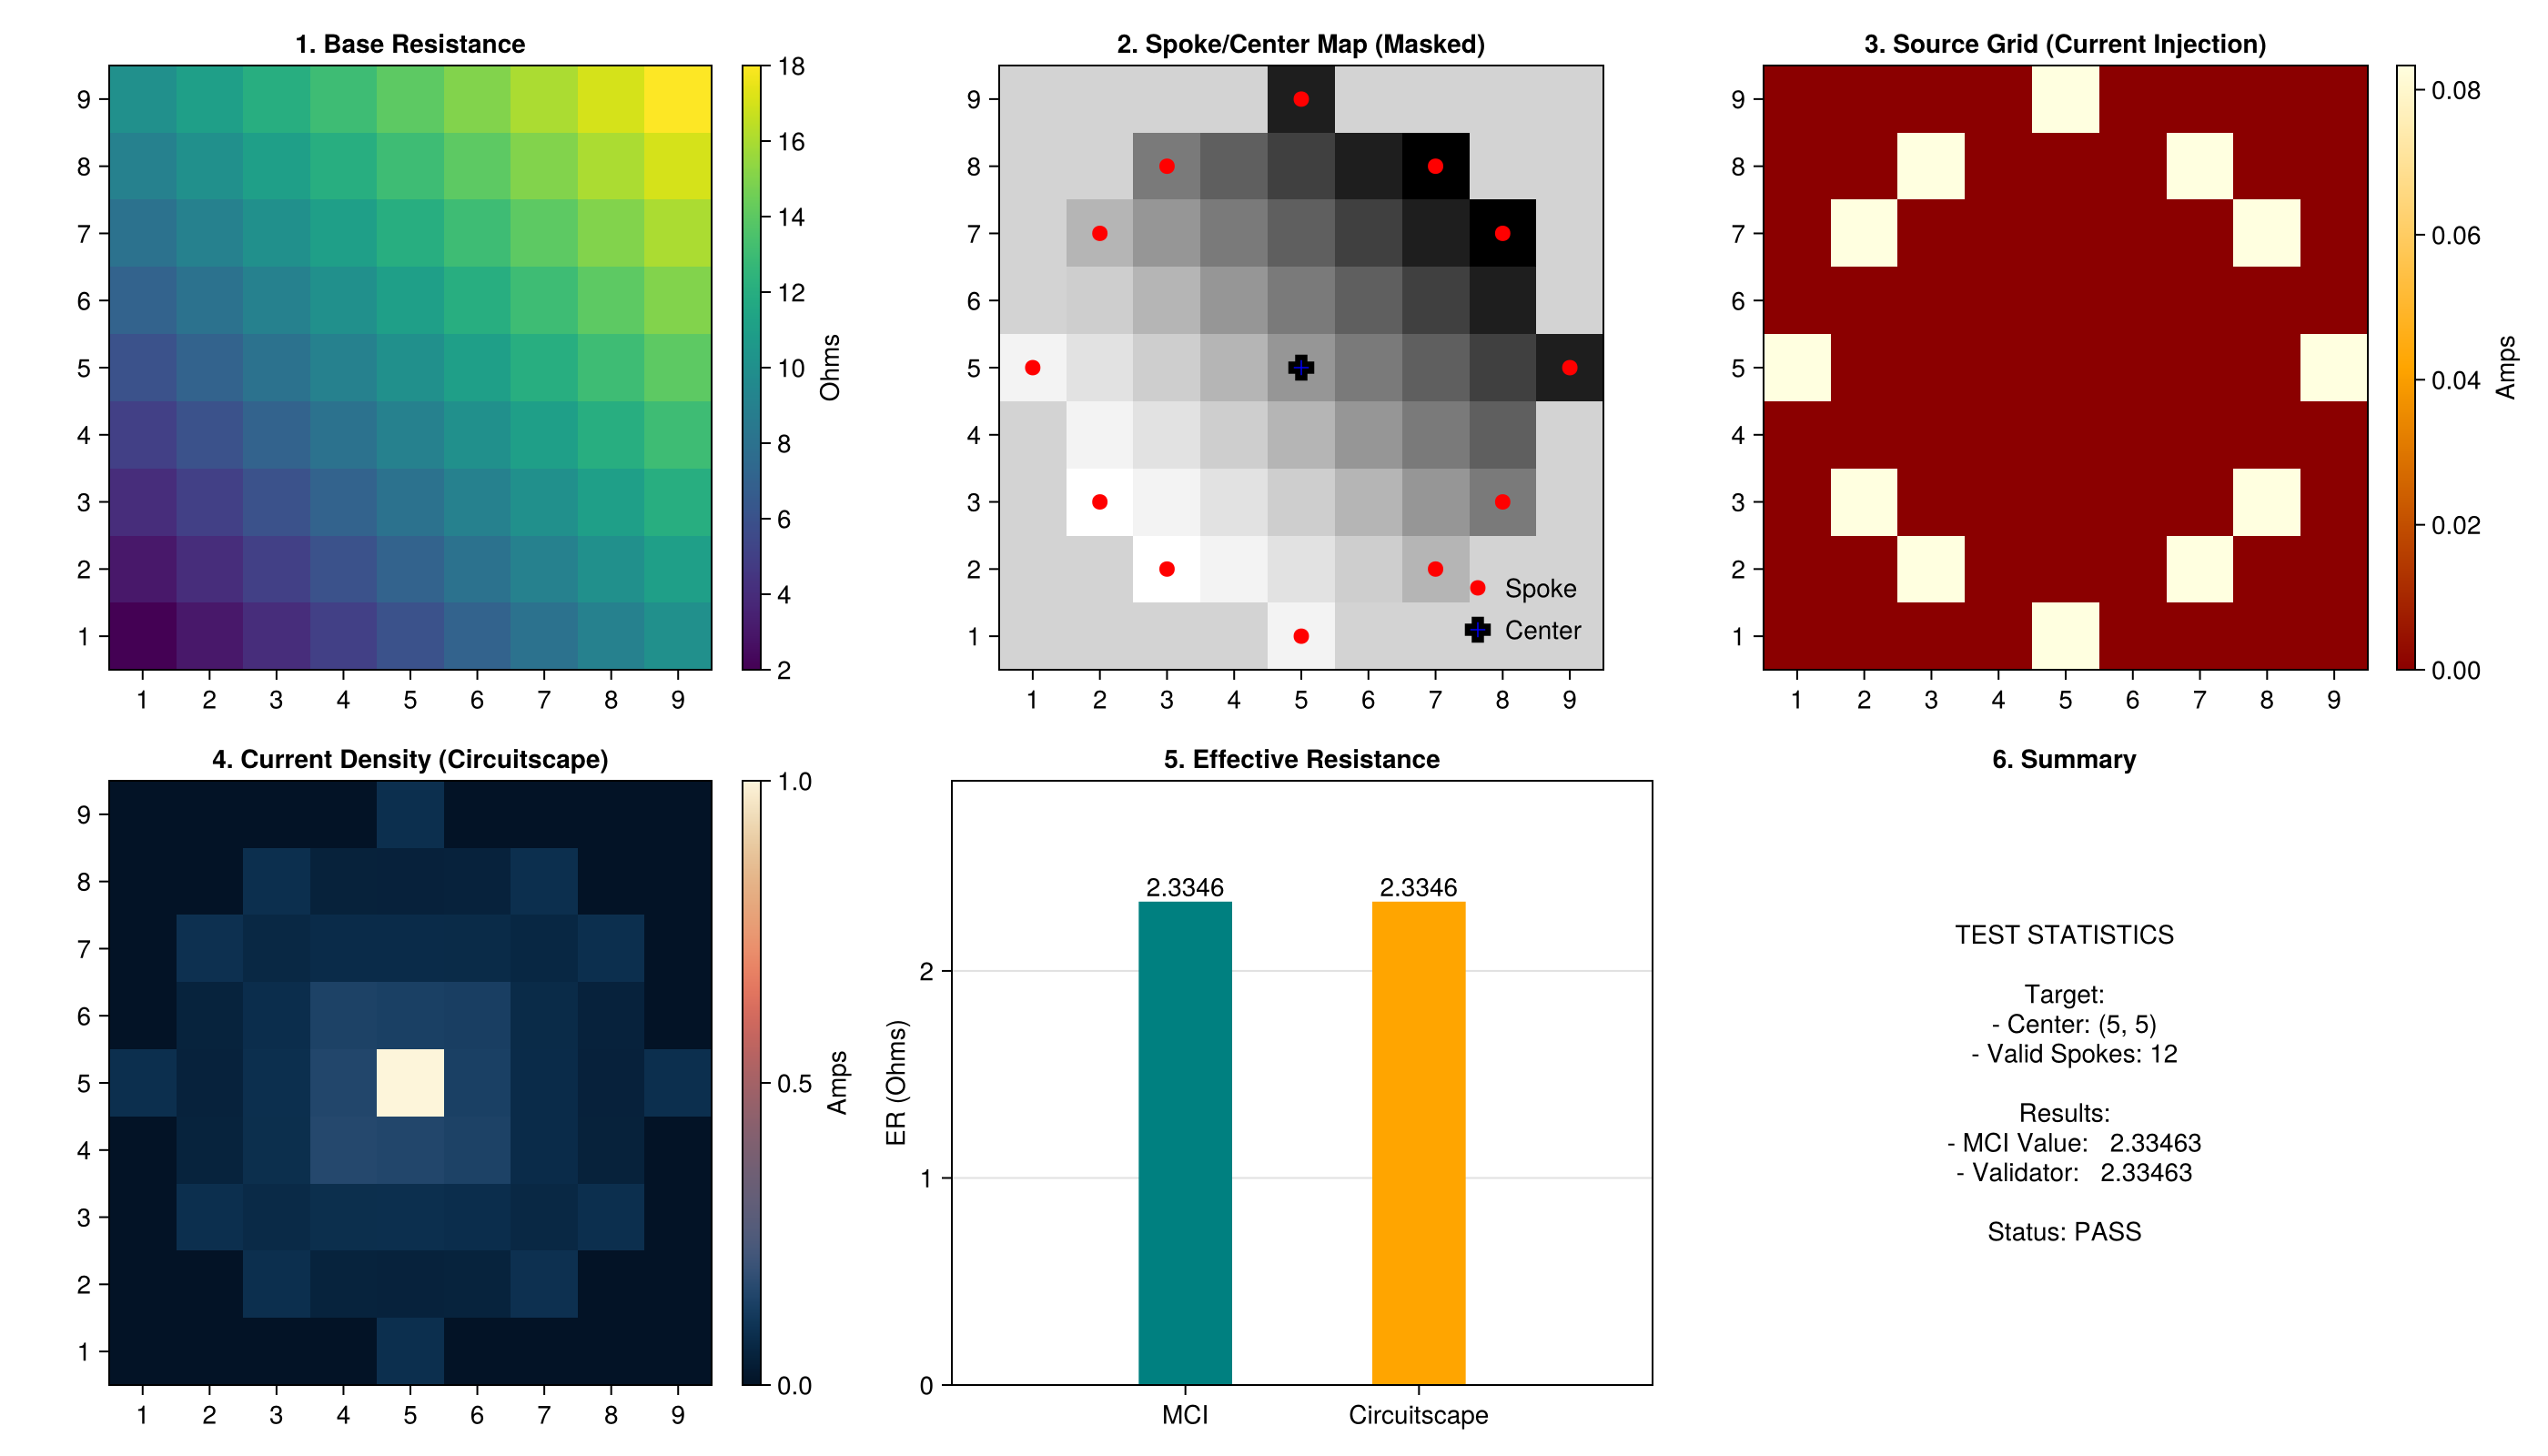

In [31]:
# Extract resistance subset for visualization
row_lo = max(1, center_r - radius)
row_hi = min(10, center_r + radius)
col_lo = max(1, center_c - radius)
col_hi = min(10, center_c + radius)
resistance_sub = resistance[row_lo:row_hi, col_lo:col_hi]
local_center_r = center_r - row_lo + 1
local_center_c = center_c - col_lo + 1

visualize_verification_square(
    "10x10 Radius 4 (12 Spokes)",
    resistance_sub, masked_cond, source_grid, cur_map, mci_val, cs_val,
    center_r = local_center_r, center_c = local_center_c
)

---

## Test 5: Sliding Window Validation (5x5 Random, Radius 1)

**Goal:** Validate MCI across **every pixel** of a random landscape.

- 5x5 random resistance grid (seeded), radius 1, 8 spokes
- MCI computes the full sliding-window raster in one call
- The validator loops over every pixel, calls `build_window_grids` for MCI's exact grids,
  and solves each window independently via Circuitscape
- Compares every valid pixel (both not NaN) within 1% tolerance

In [ ]:
Random.seed!(123)

resistance = rand(5, 5) .+ 0.1
conductance = 1.0 ./ resistance

radius = 1
num_spokes = 8

config = MerriamConnectivityIndicator.MCIConfig(
    search_radius = radius,
    num_spokes = num_spokes,
    injected_current = 1.0,
    connect_four_neighbors = false
)

# Run MCI (full sliding window)
mci_raster = MerriamConnectivityIndicator.compute_mci(resistance, config, parallelize=false, verbose=false)

# Run independent validator for every pixel
validator_raster = fill(NaN, 5, 5)s
for r in 1:5, c in 1:5
    grids = MerriamConnectivityIndicator.build_window_grids(resistance, r, c, config)
    grids === nothing && continue

    masked_cond, source_grid, ground_grid = grids
    try
        _, cs_val = compute_circuitscape_effective_resistance(
            masked_cond, source_grid, ground_grid, use_four_neighbors=false
        )
        validator_raster[r, c] = cs_val
    catch e
        # Leave as NaN if solve fails
    end
end

# Report results
valid_indices = .!isnan.(mci_raster) .& .!isnan.(validator_raster)
n_valid = count(valid_indices)

if n_valid == 0
    println("WARNING: No valid pixels for comparison!")
else
    mci_vals = mci_raster[valid_indices]
    val_vals = validator_raster[valid_indices]
    max_diff = maximum(abs.(mci_vals .- val_vals))
    println("Valid pixels compared: $n_valid")
    println("Max absolute diff:    $(round(max_diff, sigdigits=4))")
    println("Match: $(isapprox(mci_vals, val_vals, rtol=0.01) ? "PASS" : "FAIL")")
end

Valid pixels compared: 25
Max absolute diff:    0.0
Match: PASS


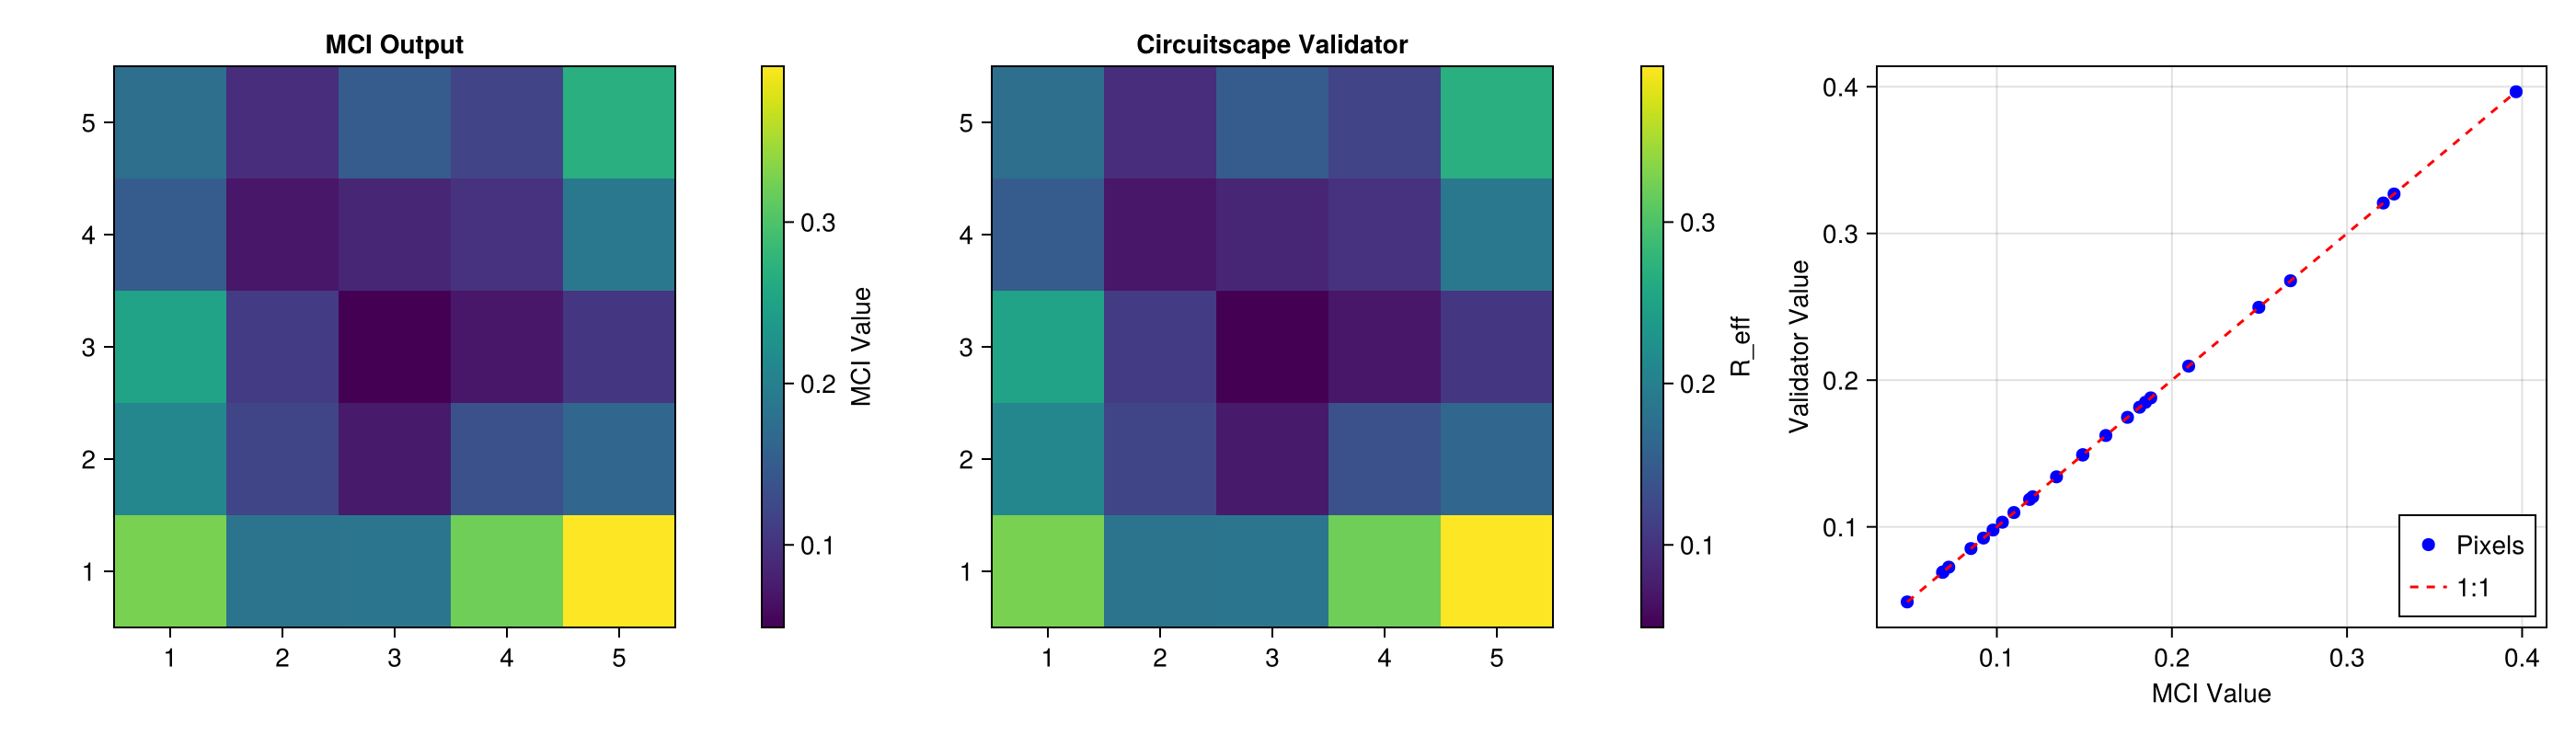

In [33]:
visualize_sliding_comparison("5x5 Random Radius 1", mci_raster, validator_raster)

---

## Pairwise Mode Tests

These tests validate MCI's pairwise mode (`compute_mci_pairwise`), which passes the center and spokes as focal nodes to Circuitscape's native pairwise solver. Instead of injecting all spoke current simultaneously (advanced mode), pairwise mode computes R_eff between each spoke-center pair independently and returns the mean.

Key properties:
- With **1 spoke**, pairwise and advanced modes are mathematically identical.
- With **multiple spokes**, pairwise R_eff > advanced R_eff because advanced mode benefits from parallel current paths that lower the combined resistance.

### Test 6: Single Spoke -- Pairwise Equals Advanced

With exactly 1 spoke, both modes inject all current at the same node. The two solutions should be identical.

In [17]:
resistance = ones(Float64, 3, 3)

config = MerriamConnectivityIndicator.MCIConfig(
    search_radius = 1, num_spokes = 1, injected_current = 1.0,
    connect_four_neighbors = true
)

adv_raster = MerriamConnectivityIndicator.compute_mci(
    resistance, config, parallelize=false, verbose=false
)
pw_raster = MerriamConnectivityIndicator.compute_mci_pairwise(
    resistance, config, parallelize=false, verbose=false
)

adv_val = adv_raster[2, 2]
pw_val  = pw_raster[2, 2]

println("Advanced R_eff: $(round(adv_val, digits=6))")
println("Pairwise R_eff: $(round(pw_val, digits=6))")
println("Match: $(isapprox(adv_val, pw_val, rtol=0.01) ? "PASS" : "FAIL")")

Advanced R_eff: 1.0
Pairwise R_eff: 1.0
Match: PASS


### Test 7: Multi-Spoke Uniform -- Pairwise > Advanced

Hmmmm

In [18]:
resistance = ones(Float64, 3, 3)

config = MerriamConnectivityIndicator.MCIConfig(
    search_radius = 1, num_spokes = 4, injected_current = 1.0,
    connect_four_neighbors = true
)

adv_val = MerriamConnectivityIndicator.compute_mci(
    resistance, config, parallelize=false, verbose=false
)[2, 2]
pw_val = MerriamConnectivityIndicator.compute_mci_pairwise(
    resistance, config, parallelize=false, verbose=false
)[2, 2]

println("Advanced R_eff: $(round(adv_val, digits=6))")
println("Pairwise R_eff: $(round(pw_val, digits=6))")
println("Pairwise > Advanced: $(pw_val > adv_val ? "PASS" : "FAIL")")

Advanced R_eff: 0.25
Pairwise R_eff: 4.0
Pairwise > Advanced: PASS
